In [7]:
# Nhập các thư viện cần thiết
import os
import cv2
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from moviepy.editor import * 
%matplotlib inline

Hiển thị cách hành động từ tập dữ liệu

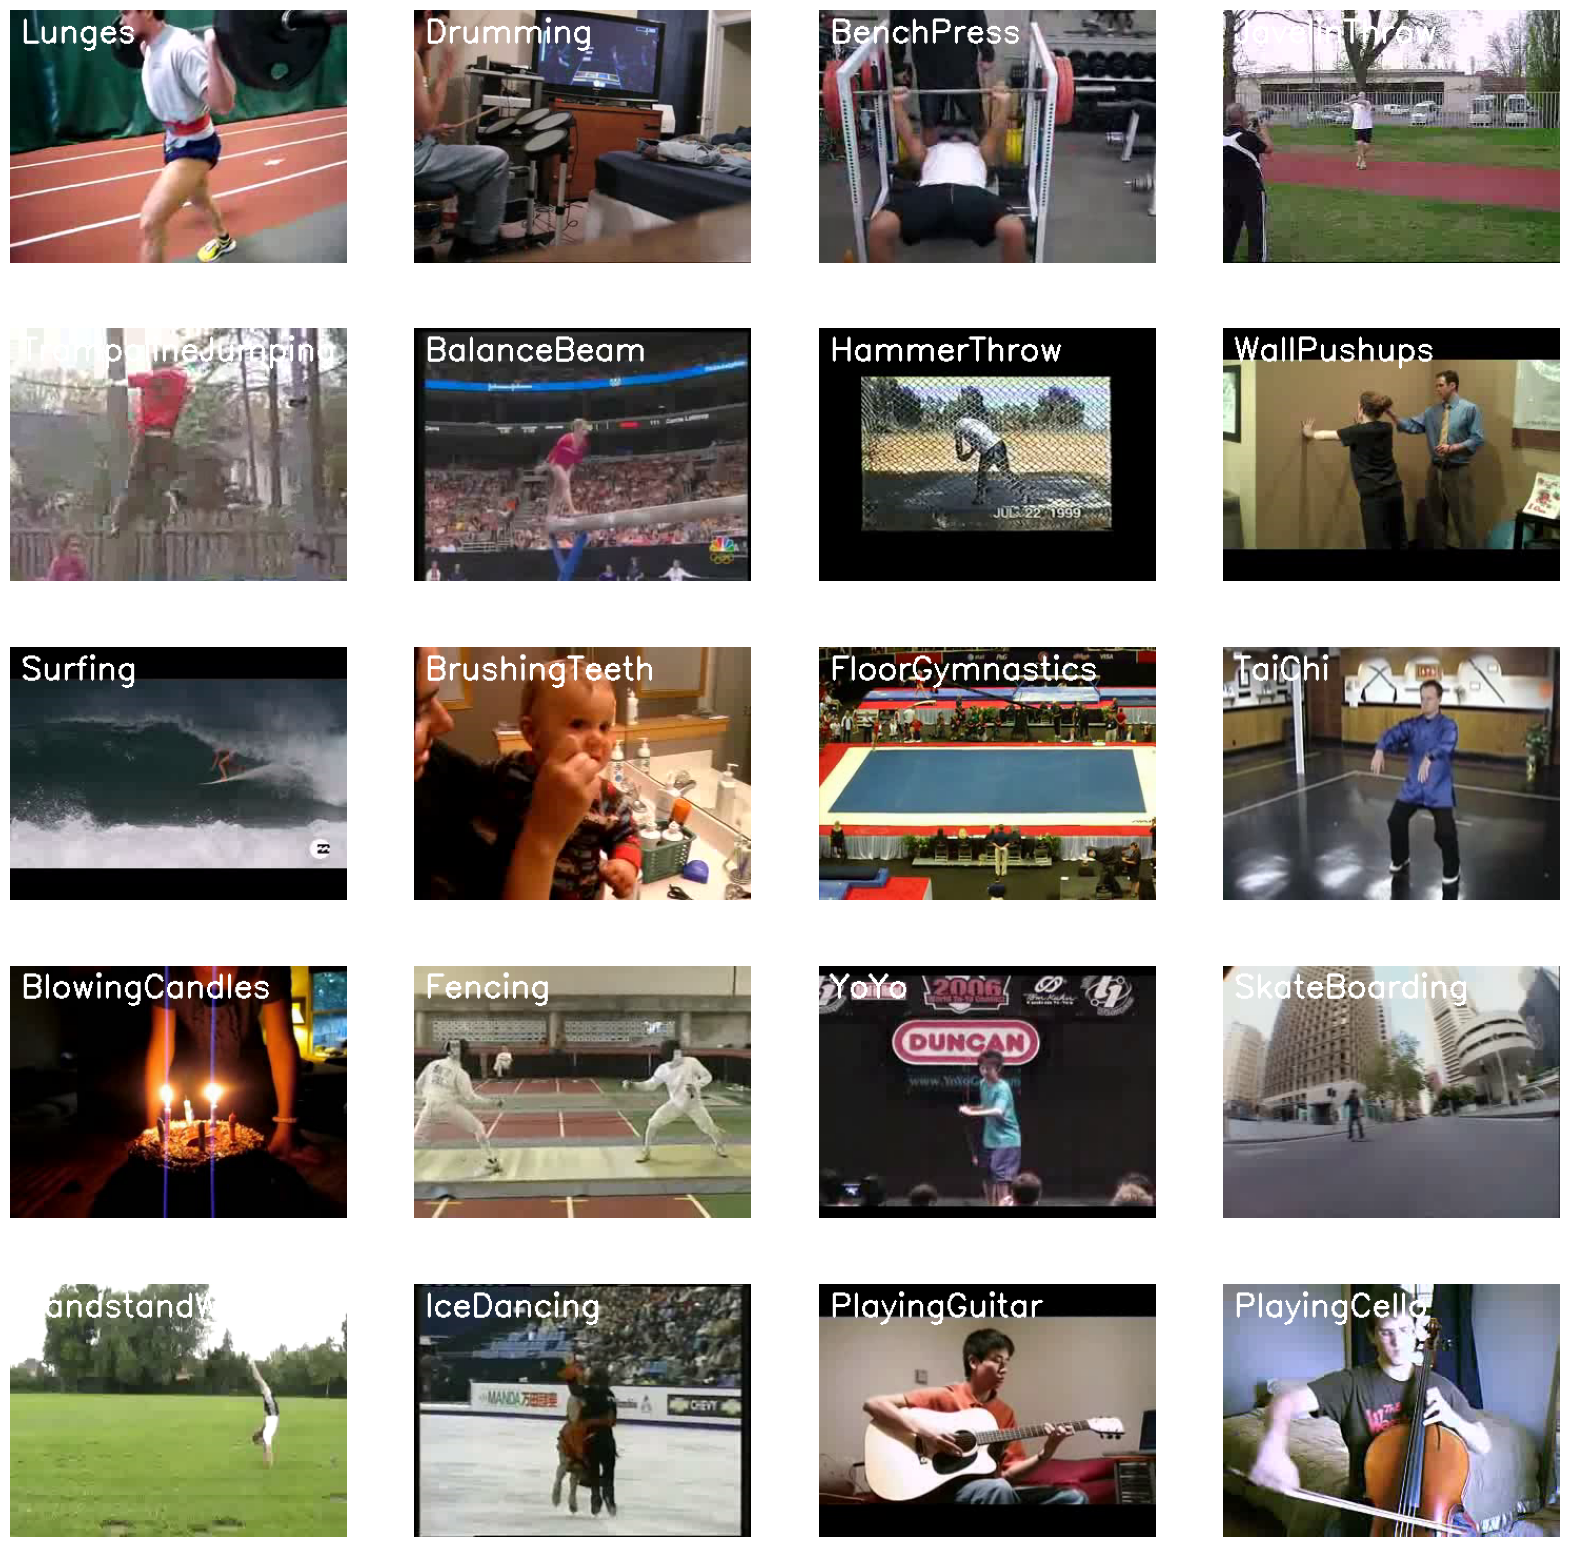

In [8]:
# Tạo một hình ảnh Matplotlib và chỉ định kích thước của nó là 20x20 inch.
plt.figure(figsize=(20, 20))
# Lấy tên của tất cả các lớp/hành động trong tập dữ liệu UCF.
all_classes_names = os.listdir("UCF-101")
# Tạo một danh sách gồm 20 số nguyên ngẫu nhiên từ 0 đến số lượng lớp trong tập dữ liệu. 
random_range = random.sample(range(len(all_classes_names)), 20)
# Bắt đầu vòng lặp để lặp qua tất cả các số ngẫu nhiên đã tạo.
for counter, random_index in enumerate(random_range, 1):
    # Lấy tên của lớp/hành động bằng cách sử dụng chỉ số ngẫu nhiên đã được tạo.
    selected_class_Name = all_classes_names[random_index]
    # Lấy danh sách tên các tệp video trong thư mục của lớp đã chọn.
    video_files_names_list = os.listdir(f'UCF-101/{selected_class_Name}')
    # Chọn một tệp video ngẫu nhiên từ danh sách tệp video đã lấy được.
    selected_video_file_name = random.choice(video_files_names_list)
    # Khởi tạo một đối tượng VideoCapture để đọc từ tệp video.
    video_reader = cv2.VideoCapture(f'UCF-101/{selected_class_Name}/{selected_video_file_name}')
    # Đọc khung hình đầu tiên từ tệp video.
    _, bgr_frame = video_reader.read()
    # Giải phóng đối tượng VideoCapture.
    video_reader.release()
    # Chuyển đổi khung hình từ không gian màu BGR sang RGB.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    # Viết tên lớp/hành động lên khung hình video.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    # Hiển thị khung hình.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

Đặt các thông số quan trọng cho việc xử lý tập dữ liệu

In [9]:
# Chiều cao và chiều rộng mà mỗi khung hình video sẽ được chuyển đổi thành.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
# Số lượng khung hình của một video sẽ được đưa vào mô hình như một chuỗi.
SEQUENCE_LENGTH = 20
# Đường dẫn đến thư mục chứa tập dữ liệu video.
DATASET_DIR = "UCF-101"
# Danh sách chứa tên các lớp được sử dụng cho việc huấn luyện mô hình: Bắn cung, Đạp xe, Cưỡi ngựa, Đi bộ cùng chó, Kéo cơ bắp, Bowling, Đấm bóng quyền, Lặn, Đánh trống, Đánh golf
CLASSES_LIST = ["Archery", "Biking", "HorseRiding", "WalkingWithDog", "BodyWeightSquats", "Bowling", "BoxingPunchingBag", "Diving", "Drumming", "GolfSwing"]

Trích đặc trưng

In [10]:
def frames_extraction(video_path):
    # Khai báo một danh sách để lưu trữ các khung hình của video.
    frames_list = []
    # Đọc tệp video bằng đối tượng VideoCapture.
    video_reader = cv2.VideoCapture(video_path)
    # Lấy tổng số khung hình trong video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # Tính toán khoảng cách giữa các khung hình mà sẽ được thêm vào danh sách.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    # Lặp qua các khung hình của video.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Đặt vị trí khung hình hiện tại của video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        # Đọc khung hình từ video.
        success, frame = video_reader.read()
        # Kiểm tra xem khung hình của video có được đọc thành công không, nếu không thì thoát khỏi vòng lặp.
        if not success:
            break
        # Điều chỉnh kích thước của khung hình để có kích thước cố định.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # Chuẩn hóa khung hình đã điều chỉnh kích thước bằng cách chia cho 255 để mỗi giá trị pixel nằm trong khoảng từ 0 đến 1.
        normalized_frame = resized_frame / 255
        # Thêm khung hình đã chuẩn hóa vào danh sách các khung hình.
        frames_list.append(normalized_frame)
    # Giải phóng đối tượng VideoCapture.
    video_reader.release()
    # Trả về danh sách các khung hình.
    return frames_list


In [11]:
# Trích đặc trưng ,labels,video_files_paths từ thư mục DATASET_DIR theo danh sách CLASSES_LIST 
def create_dataset():
    # Khai báo các danh sách rỗng để lưu trữ các đặc trưng, nhãn và đường dẫn tập tin video.
    features = []
    labels = []
    video_files_paths = []
    # Lặp qua tất cả các lớp được đề cập trong danh sách các lớp.
    for class_index, class_name in enumerate(CLASSES_LIST):
        # Hiển thị tên của lớp đang được trích xuất dữ liệu.
        print(f'Extracting Data of Class: {class_name}')
        # Lấy danh sách các tệp video có trong thư mục của lớp cụ thể.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        # Lặp qua tất cả các tệp có trong danh sách tệp.
        for file_name in files_list:
            # Lấy đường dẫn đầy đủ của tệp video.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            # Trích xuất các khung hình từ tệp video.
            frames = frames_extraction(video_file_path)
            # Kiểm tra xem số lượng khung hình trích xuất có bằng với SEQUENCE_LENGTH được chỉ định không.
            # Nếu không, bỏ qua video có số lượng khung hình ít hơn SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
                # Thêm dữ liệu vào các danh sách tương ứng của chúng.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    # Chuyển đổi các danh sách thành mảng numpy.
    features = np.asarray(features)
    labels = np.array(labels)
    # Trả về các đặc trưng, nhãn và đường dẫn tập tin video.
    return features, labels, video_files_paths

In [12]:
# Tạo tập dữ liệu.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Archery
Extracting Data of Class: Biking
Extracting Data of Class: HorseRiding
Extracting Data of Class: WalkingWithDog
Extracting Data of Class: BodyWeightSquats
Extracting Data of Class: Bowling
Extracting Data of Class: BoxingPunchingBag
Extracting Data of Class: Diving
Extracting Data of Class: Drumming
Extracting Data of Class: GolfSwing


In [13]:
#Chuyển đổi nhãn dạng nguyên thành dạng one shot
one_hot_encoded_labels = to_categorical(labels)

In [14]:
#Chia tập dữ liệu Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                          test_size=0.25, shuffle=True,
                                                                          random_state=42)

Xây dựng mô hình LRCN

In [15]:
def create_LRCN_model():
    # Sử dụng một mô hình Sequential để xây dựng mô hình.
    model = Sequential()
    # Định nghĩa Kiến trúc của Mô hình.
    # Đầu vào là một chuỗi hình ảnh (video), trong đó mỗi hình ảnh có kích thước IMAGE_WIDTH x IMAGE_HEIGHT và được lấy mẫu theo SEQUENCE_LENGTH khung hình.
    # Mỗi khung hình trong chuỗi được đưa qua một lớp convolutional 2D với 64 bộ lọc, kernel kích thước 4x4 và hàm kích hoạt ReLU.
    model.add(TimeDistributed(Conv2D(64, (4, 4), padding='same', activation='relu'), input_shape=(SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    # Sau đó, một lớp max pooling 2D với kích thước cửa sổ 4x4 được áp dụng để giảm kích thước không gian.
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    # Lớp dropout với tỷ lệ là 0.3 được thêm vào để ngăn chặn việc quá mức hóa.
    model.add(TimeDistributed(Dropout(0.3)))
    # Quá trình trên được lặp lại hai lần nữa với số lượng bộ lọc tăng lên, lần lượt là 128 và 256.
    model.add(TimeDistributed(Conv2D(128, (4, 4), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.3)))
    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same', activation='relu')))
    # Một lớp convolutional cuối cùng với 256 bộ lọc và kernel 2x2 được áp dụng.
    # Sau đó, một lớp global max pooling theo chiều thời gian được sử dụng để chọn ra giá trị lớn nhất trong mỗi kênh thời gian.
    model.add(TimeDistributed(GlobalMaxPooling2D()))
    # Một lớp LSTM với 256 đơn vị được thêm vào để mô hình hóa các mối quan hệ thời gian giữa các khung hình.
    model.add(LSTM(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.1)))
    # Output của lớp LSTM được làm phẳng để có thể đưa vào một lớp fully connected.                           
    model.add(Flatten())                                                                 
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    # Hiển thị tóm tắt của mô hình.
    model.summary()
    # Trả về mô hình LRCN được xây dựng.
    return model

In [16]:
# Xây dựng mô hình LRCN bằng cách gọi hàm create_LRCN_model(). Kết quả được gán cho biến LRCN_model.
LRCN_model = create_LRCN_model()
# In ra thông báo "Model Created Successfully!" để thông báo rằng mô hình đã được tạo thành công.
print("Model Created Successfully!")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 64)    3136      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 128)   131200    
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 128)    

Biên dịch mô hình

In [17]:
# Biên dịch mô hình và chỉ định hàm mất mát, bộ tối ưu hóa và các đánh giá cho mô hình.
LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
# Bắt đầu huấn luyện mô hình.
LRCN_model_training_history = LRCN_model.fit(
    x=features_train,  # Đặc trưng huấn luyện
    y=labels_train,    # Nhãn huấn luyện
    epochs=150,        # Số epoch cho quá trình huấn luyện
    batch_size=32,     # Kích thước batch
    shuffle=True,      # Xáo trộn dữ liệu huấn luyện
    validation_split=0.2  # Chia dữ liệu validation từ dữ liệu huấn luyện với tỷ lệ 20%
)


Epoch 1/150


28/28 [==============================] - 28s 880ms/step - loss: 25.6836 - accuracy: 0.1246 - val_loss: 11.6449 - val_accuracy: 0.1797
Epoch 2/150
28/28 [==============================] - 22s 799ms/step - loss: 6.8867 - accuracy: 0.1938 - val_loss: 3.5213 - val_accuracy: 0.2350
Epoch 3/150
28/28 [==============================] - 22s 787ms/step - loss: 2.6204 - accuracy: 0.2330 - val_loss: 2.0686 - val_accuracy: 0.3502
Epoch 4/150
28/28 [==============================] - 22s 789ms/step - loss: 1.9493 - accuracy: 0.3010 - val_loss: 1.8988 - val_accuracy: 0.3134
Epoch 5/150
28/28 [==============================] - 22s 789ms/step - loss: 1.7809 - accuracy: 0.3668 - val_loss: 1.6323 - val_accuracy: 0.3963
Epoch 6/150
28/28 [==============================] - 23s 812ms/step - loss: 1.7037 - accuracy: 0.3772 - val_loss: 1.6647 - val_accuracy: 0.3594
Epoch 7/150
28/28 [==============================] - 23s 818ms/step - loss: 1.5447 - accuracy: 0.4452 - val_loss: 1.4738 - val_accu

Đánh giá mô hình đã được huấn luyện

In [18]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

12/12 [==============================] - 3s 209ms/step - loss: 0.7523 - accuracy: 0.8536


Lưu mô hình

In [19]:
# Lưu mô hình với tên "model3.h5".
LRCN_model.save("model3.h5")